**Building a Recommender System with Grammatical Evolution**

Implementation by Nutsa Chichilidze 

University of Limerick, 2022

Final Year Project

# Imports

In [1]:
# ! pip install deap==1.3 

import pandas as pd 
import numpy as np
import warnings

%cd ./grape
from ponyge2_adapted_files import Grammar, ge
import algorithms
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math 
from deap import creator, base, tools
from sklearn.model_selection import train_test_split
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from collections import defaultdict

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

pd.set_option('float_format', '{:f}'.format)
warnings.filterwarnings("ignore")

from functions import div, plog, psqrt, exp
from functions import add, sub, mul, pdiv, neg, and_, or_, not_, less_than_or_equal, greater_than_or_equal

/Users/nutsa/Desktop/RS-with-GE/submission/grape


# Data Engineering

## Data Collection

### MovieLens Collection

In [8]:
movies = pd.read_csv('https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/data/preprocessed_movielens_1m/movies.csv')
tags = pd.read_csv('https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/data/preprocessed_movielens_1m/tags.csv')
ratings = pd.read_csv('https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/data/preprocessed_movielens_1m/ratings.csv')
users = pd.read_csv('https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/data/preprocessed_movielens_1m/users.csv')

movies = movies.iloc[: , 1:]
tags = tags.iloc[: , 1:]
ratings = ratings.iloc[: , 1:]
users = users.iloc[: , 1:]

**Movies**

The data has been preprocessed: genres were lowercased and the year and the title have been separated

In [9]:
movies.head()

,movie_id,title,genres,year
0,1,Toy Story,animation children's comedy,1995
1,2,Jumanji,adventure children's fantasy,1995
2,3,Grumpier Old Men,comedy romance,1995
3,4,Waiting to Exhale,comedy drama,1995
4,5,Father of the Bride Part II,comedy,1995


In [10]:
tags.head()

,movie_id,tags,title,genres,year
0,1,pixar pixar pixar animation pixar animated fun...,Toy Story,animation children's comedy,1995
1,2,for children game animals joe johnston robin w...,Jumanji,adventure children's fantasy,1995
2,3,funniest movies comedinha de velhinhos engraã ...,Grumpier Old Men,comedy romance,1995
3,4,girl movie comedy drama comedy drama comedy dr...,Waiting to Exhale,comedy drama,1995
4,5,steve martin pregnancy remake steve martin fam...,Father of the Bride Part II,comedy,1995


In [11]:
users.head()

,user_id,gender,age
0,1,1,1
1,2,0,56
2,3,0,25
3,4,0,45
4,5,0,25


In [12]:
ratings.head()

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


calculate average MovieLens rating and the number of votes each movie has on MovieLens

In [13]:
for index, row in movies.iterrows():    
    movie_id = row['movie_id'] 
    
    ratings_data = ratings[ratings['movie_id'] == movie_id]
    ratings_sum = ratings_data['rating'].sum()
    ratings_count = len(ratings_data)
    
    if (ratings_count != 0):
        ml_rating = int(ratings_sum) / int(ratings_count)
    else: 
        ml_rating = 0
        
    movies.at[index, 'ml_rating'] = ml_rating
    movies.at[index, 'ml_votes'] = ratings_count

In [14]:
movies.head()

,movie_id,title,genres,year,ml_rating,ml_votes
0,1,Toy Story,animation children's comedy,1995,4.146846,2077.000000
1,2,Jumanji,adventure children's fantasy,1995,3.201141,701.000000
2,3,Grumpier Old Men,comedy romance,1995,3.016736,478.000000
3,4,Waiting to Exhale,comedy drama,1995,2.729412,170.000000
4,5,Father of the Bride Part II,comedy,1995,3.006757,296.000000


### IMDB Collection

In [15]:
imdb_data = pd.read_csv('https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/data/movies/imdb_shortened.csv')

In [16]:
imdb_data.head()

,tconst,averageRating,numVotes,titleType,title,originalTitle,isAdult,year,runtimeMinutes,imdb_genres
0,tt0010418,7.000000,1853,movie,male and female,Male and Female,0,1919,116,"Adventure,Drama"
1,tt0011652,6.100000,1565,movie,the saphead,The Saphead,0,1920,77,Comedy
2,tt0012349,8.300000,123451,movie,the kid,The Kid,0,1921,68,"Comedy,Drama,Family"
3,tt0013442,7.900000,94382,movie,nosferatu,"Nosferatu, eine Symphonie des Grauens",0,1922,94,"Fantasy,Horror"
4,tt0013662,7.100000,475,movie,tess of the storm country,Tess of the Storm Country,0,1922,137,"Drama,Romance"


In [17]:
imdb_data = imdb_data.drop(columns = ['titleType', 'originalTitle', 'imdb_genres'])

In [18]:
imdb_data.head()

,tconst,averageRating,numVotes,title,isAdult,year,runtimeMinutes
0,tt0010418,7.000000,1853,male and female,0,1919,116
1,tt0011652,6.100000,1565,the saphead,0,1920,77
2,tt0012349,8.300000,123451,the kid,0,1921,68
3,tt0013442,7.900000,94382,nosferatu,0,1922,94
4,tt0013662,7.100000,475,tess of the storm country,0,1922,137


In [19]:
map_ml_imdb = pd.read_csv('https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/data/movies/matched_movies_ML_IMDB.csv')

In [20]:
map_ml_imdb.head()

,movie_id,title,year,tconst
0,1,toy story,1995.000000,tt0114709
1,2,jumanji,1995.000000,tt0113497
2,3,grumpier old men,1995.000000,tt0113228
3,4,waiting to exhale,1995.000000,tt0114885
4,5,father of the bride part ii,1995.000000,tt0113041


In [21]:
map_ml_imdb['movie_id'].count()

3808

In [22]:
movies['movie_id'].count()

3883

In [23]:
imdb_data.dtypes

tconst             object
averageRating     float64
numVotes            int64
title              object
isAdult             int64
year                int64
runtimeMinutes      int64
dtype: object

In [24]:
movies.dtypes

movie_id       int64
title         object
genres        object
year           int64
ml_rating    float64
ml_votes     float64
dtype: object

In [25]:
map_ml_imdb.dtypes

movie_id      int64
title        object
year        float64
tconst       object
dtype: object

In [26]:
map_ml_imdb = map_ml_imdb.astype({'tconst': 'string', 
                                  'title': 'string'})

movies = movies.astype({'genres': 'string', 
                        'title': 'string'})

imdb_data = imdb_data.astype({'tconst': 'string', 
                              'title': 'string'})

In [27]:
movies['imdb_rating'] = -1
movies['imdb_votes'] = -1
movies['is_adult'] = -1
movies['runtime_minutes'] = -1

In [28]:
imdb_df_ids = list(map_ml_imdb['movie_id'])

for index, row in movies.iterrows():
    movie_id = int(row['movie_id'])

    if movie_id in imdb_df_ids: 
        tconst = map_ml_imdb[map_ml_imdb['movie_id'] == movie_id]
        tconst = tconst['tconst']
        tconst = str(tconst.values[0])
        imdb_row = imdb_data[imdb_data['tconst'] == tconst]
        if (len(imdb_row['averageRating'].values) > 0):
            movies.at[index, 'imdb_rating'] = imdb_row['averageRating']
        if (len(imdb_row['numVotes'].values) > 0):
            movies.at[index,'imdb_votes'] = imdb_row['numVotes']
        if (len(imdb_row['isAdult'].values) > 0):
            movies.at[index,'is_adult'] = imdb_row['isAdult']
        if (len(imdb_row['runtimeMinutes'].values) > 0):
            movies.at[index,'runtime_minutes'] = imdb_row['runtimeMinutes']

In [29]:
movies.head()

,movie_id,title,genres,year,ml_rating,ml_votes,imdb_rating,imdb_votes,is_adult,runtime_minutes
0,1,Toy Story,animation children's comedy,1995,4.146846,2077.000000,8,953300,0,81
1,2,Jumanji,adventure children's fantasy,1995,3.201141,701.000000,7,333517,0,104
2,3,Grumpier Old Men,comedy romance,1995,3.016736,478.000000,6,26811,0,101
3,4,Waiting to Exhale,comedy drama,1995,2.729412,170.000000,5,10757,0,124
4,5,Father of the Bride Part II,comedy,1995,3.006757,296.000000,6,37343,0,106


In [30]:
len(movies)

3883

### TMDB Collection

In [31]:
map_ml_tmdb = pd.read_csv('https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/data/movies/matched_movies_ML_TMBD.csv')

In [32]:
map_ml_tmdb.head()

,movie_id,title,genres,year,original_language,budget,overview,popularity,revenue,tagline,tmdb_vote_avg,tmdb_vote_count,tmdb_id
0,1,toy story,animation children's comedy,1995,en,30000000,"Led by Woody, Andy's toys live happily in his ...",165,373554033,NaN,8,15156,27475
1,2,jumanji,adventure children's fantasy,1995,en,125000000,As the gang return to Jumanji to rescue one of...,122,800059707,NaN,7,6769,27475
2,3,grumpier old men,comedy romance,1995,en,25000000,A family wedding reignites the ancient feud be...,9,71500000,Still Yelling. Still Fighting. Still Ready for...,6,288,27475
3,4,waiting to exhale,comedy drama,1995,en,16000000,"Cheated on, mistreated and stepped on, the wom...",8,81452156,Friends are the people who let you be yourself...,6,120,27475
4,5,father of the bride part ii,comedy,1995,en,0,Just when George Banks has recovered from his ...,14,76594107,Just When His World Is Back To Normal... He's ...,6,561,27475


In [33]:
movies['budget'] = -1
movies['original_language'] = ''
movies['overview'] = ''
movies['popularity'] = -1
movies['revenue'] = -1
movies['tagline'] = ''
movies['tmdb_vote_count'] = -1
movies['tmdb_vote_avg'] = -1

movies.reset_index()
 
count = 0
for index, row in movies.iterrows():
    if (index % 500 == 0): 
        print(index)
    movie_id = int(row['movie_id'])
    tmdb_row = map_ml_tmdb[map_ml_tmdb['movie_id'] == movie_id]
    
    movies.at[index, 'budget'] = tmdb_row['budget'].values[0]
    movies.at[index,'original_language'] = tmdb_row['original_language'].values[0]
    movies.at[index,'overview'] = tmdb_row['overview'].values[0]
    movies.at[index,'popularity'] = tmdb_row['popularity'].values[0]
    movies.at[index,'revenue'] = tmdb_row['revenue'].values[0]
    movies.at[index,'tagline'] = tmdb_row['tagline'].values[0]
    movies.at[index,'tmdb_vote_count'] = tmdb_row['tmdb_vote_count'].values[0]
    movies.at[index,'tmdb_vote_avg'] = tmdb_row['tmdb_vote_avg'].values[0]

0
500
1000
1500
2000
2500
3000
3500


In [34]:
movies.head()

,movie_id,title,genres,year,ml_rating,ml_votes,imdb_rating,imdb_votes,is_adult,runtime_minutes,budget,original_language,overview,popularity,revenue,tagline,tmdb_vote_count,tmdb_vote_avg
0,1,Toy Story,animation children's comedy,1995,4.146846,2077.000000,8,953300,0,81,30000000,en,"Led by Woody, Andy's toys live happily in his ...",165,373554033,NaN,15156,8
1,2,Jumanji,adventure children's fantasy,1995,3.201141,701.000000,7,333517,0,104,125000000,en,As the gang return to Jumanji to rescue one of...,122,800059707,NaN,6769,7
2,3,Grumpier Old Men,comedy romance,1995,3.016736,478.000000,6,26811,0,101,25000000,en,A family wedding reignites the ancient feud be...,9,71500000,Still Yelling. Still Fighting. Still Ready for...,288,6
3,4,Waiting to Exhale,comedy drama,1995,2.729412,170.000000,5,10757,0,124,16000000,en,"Cheated on, mistreated and stepped on, the wom...",8,81452156,Friends are the people who let you be yourself...,120,6
4,5,Father of the Bride Part II,comedy,1995,3.006757,296.000000,6,37343,0,106,0,en,Just when George Banks has recovered from his ...,14,76594107,Just When His World Is Back To Normal... He's ...,561,6


## Content-Based Filtering Engine

In [35]:
tags = pd.read_csv('https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/progress/content%20based%20filtering/movies_cbf.csv',lineterminator='\n')
tags = tags.astype({'year': 'string'})
tags['title_and_year'] = tags['title'] + ' (' + tags['year'] + ')'

In [36]:
tags.head()

,movie_id,title,year,overview,tagline,tags,tags_full,title_and_year
0,1,toy story,1995,"Led by Woody, Andy's toys live happily in his ...",NaN,pixar pixar pixar animation pixar animated fun...,pixar pixar pixar animation pixar animated fun...,toy story (1995)
1,2,jumanji,1995,When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!,for children game animals joe johnston robin w...,for children game animals joe johnston robin w...,jumanji (1995)
2,3,grumpier old men,1995,A family wedding reignites the ancient feud be...,Still Yelling. Still Fighting. Still Ready for...,funniest movies comedinha de velhinhos engraã ...,funniest movies comedinha de velhinhos engraã ...,grumpier old men (1995)
3,4,waiting to exhale,1995,"Cheated on, mistreated and stepped on, the wom...",Friends are the people who let you be yourself...,girl movie comedy drama comedy drama comedy dr...,girl movie comedy drama comedy drama comedy dr...,waiting to exhale (1995)
4,5,father of the bride part ii,1995,Just when George Banks has recovered from his ...,Just When His World Is Back To Normal... He's ...,steve martin pregnancy remake steve martin fam...,steve martin pregcy remake steve martin family...,father of the bride part ii (1995)


In [37]:
tags.at[0, 'tags_full']

'pixar pixar pixar animation pixar animated fun toy toys pixar rated g pixar pixar national film registry time travel pixar pixar funny imdb top animation very good ya boy pixar time travel animation erlend s dvds cgi disney family pixar toys bright daring rescues fanciful heroic mission humorous light rousing toys come to life unlikely friendships warm witty pixar the boys almost favorite é ä é animation children disney pixar clever want to see again cartoon disney d computer animation disney animated feature pixar animation want buddy movie animation pixar tim allen tom hanks animation disney pixar toys computer animation cartoon pixar animation computer animation pixar toys tumey s to see again tumey s vhs classic disney engaging avi buy action figure action figures buzz lightyear cg animation toy toys woody disney pixar tim allen tom hanks animation pixar animation kids movie pixar tim allen time travel animation cgi adventure animation children comedy animation pixar lots of heart

### Build the Engine that is able to recommend 50 similar movies

In [38]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
matrix = tf.fit_transform(tags['tags_full'])

cosine_similarities = linear_kernel(matrix,matrix)
movie_titles = tags['title_and_year']
indices = pd.Series(tags.index, index=tags['title_and_year'])

In [39]:
def recommend_movies(original_title):
    # recommends 50 movies 
    idx = indices[original_title]
    sim_scores = list(enumerate(cosine_similarities[idx]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:51]

    movie_indices = [i[0] for i in sim_scores]
    titles = movie_titles.iloc[movie_indices]
    return titles, movie_indices

In [40]:
recommend_movies('toy story (1995)')

(3045                                toy story 2 (1999)
 2286                              bug's life, a (1998)
 2225                                       antz (1998)
 2285                         rugrats movie, the (1998)
 1050            aladdin and the king of thieves (1996)
 2009                           jungle book, the (1967)
 3685    adventures of rocky and bullwinkle, the (2000)
 2073        american tail: fievel goes west, an (1991)
 2072                          american tail, an (1986)
 3542                             saludos amigos (1943)
 2011                         lady and the tramp (1955)
 592                                   pinocchio (1940)
 584                                     aladdin (1992)
 3682                                chicken run (2000)
 12                                        balto (1995)
 2033                           steamboat willie (1940)
 1262                                   fantasia (1940)
 2012                        little mermaid, the

In [41]:
recommend_movies('clueless (1995)')

(16                           sense and sensibility (1995)
 827                                           emma (1996)
 27                                      persuasion (1995)
 3010                                mansfield park (1999)
 6                                          sabrina (1995)
 797     rendezvous in paris (rendez-vous de paris, les...
 1589                           smile like yours, a (1997)
 3759                               mad about mambo (2000)
 2                                 grumpier old men (1995)
 2400                         peggy sue got married (1986)
 1511                               trial and error (1997)
 3284                           closer you get, the (2000)
 2416                                she's all that (1999)
 3289                           defending your life (1991)
 1426                 beautician and the beast, the (1997)
 3028                   shop around the corner, the (1940)
 67                     french twist (gazon maudit) (199

### generate a list of similar movies for each movie in the movies data

In [42]:
similar_movies = movies.copy(deep=True)
similar_movies.head()

,movie_id,title,genres,year,ml_rating,ml_votes,imdb_rating,imdb_votes,is_adult,runtime_minutes,budget,original_language,overview,popularity,revenue,tagline,tmdb_vote_count,tmdb_vote_avg
0,1,Toy Story,animation children's comedy,1995,4.146846,2077.000000,8,953300,0,81,30000000,en,"Led by Woody, Andy's toys live happily in his ...",165,373554033,NaN,15156,8
1,2,Jumanji,adventure children's fantasy,1995,3.201141,701.000000,7,333517,0,104,125000000,en,As the gang return to Jumanji to rescue one of...,122,800059707,NaN,6769,7
2,3,Grumpier Old Men,comedy romance,1995,3.016736,478.000000,6,26811,0,101,25000000,en,A family wedding reignites the ancient feud be...,9,71500000,Still Yelling. Still Fighting. Still Ready for...,288,6
3,4,Waiting to Exhale,comedy drama,1995,2.729412,170.000000,5,10757,0,124,16000000,en,"Cheated on, mistreated and stepped on, the wom...",8,81452156,Friends are the people who let you be yourself...,120,6
4,5,Father of the Bride Part II,comedy,1995,3.006757,296.000000,6,37343,0,106,0,en,Just when George Banks has recovered from his ...,14,76594107,Just When His World Is Back To Normal... He's ...,561,6


In [43]:
similar_movies = tags.copy(deep=True)
similar_movies= similar_movies.drop(columns =['tags_full', 'tags', 'tagline', 'overview', 'year'])
similar_movies.head()

,movie_id,title,title_and_year
0,1,toy story,toy story (1995)
1,2,jumanji,jumanji (1995)
2,3,grumpier old men,grumpier old men (1995)
3,4,waiting to exhale,waiting to exhale (1995)
4,5,father of the bride part ii,father of the bride part ii (1995)


In [44]:
similar_movies['similar_movies'] = None

for index, row in similar_movies.iterrows():
    title = str(row['title_and_year'])
    t, m_i = recommend_movies(title)
    tags.reset_index() 
    similar_movies_list = []
    
    for i in m_i: 
        similar_movie = int(tags.at[i, 'movie_id'])
        similar_movies_list.append(similar_movie)
    
    similar_movies.at[index, 'similar_movies'] = similar_movies_list

In [45]:
similar_movies.head()

,movie_id,title,title_and_year,similar_movies
0,1,toy story,toy story (1995),"[3114, 2355, 2294, 2354, 1064, 2078, 3754, 214..."
1,2,jumanji,jumanji (1995),"[56, 60, 126, 2162, 2161, 2005, 1967, 2399, 10..."
2,3,grumpier old men,grumpier old men (1995),"[7, 807, 1632, 1550, 3353, 3097, 3829, 3358, 3..."
3,4,waiting to exhale,waiting to exhale (1995),"[819, 1630, 1774, 106, 476, 2290, 568, 2239, 1..."
4,5,father of the bride part ii,father of the bride part ii (1995),"[643, 651, 856, 2923, 1001, 739, 2155, 275, 38..."


### generate a list of favourite movies for each user

In [46]:
users = list(ratings['user_id'].unique())
user_favourite_movies = pd.DataFrame(); 
user_favourite_movies['user'] = None
user_favourite_movies['favourite_movies'] = None

rating_threshold = 4 

for user_id in users: 
    movies_rated_by_user = ratings[ratings['user_id'] == user_id]
    highly_rated = movies_rated_by_user.loc[movies_rated_by_user['rating'] >= rating_threshold]['movie_id'].values
    
    new_row = {'user': user_id, 'favourite_movies': list(highly_rated)}
    user_favourite_movies = user_favourite_movies.append(new_row, ignore_index = True)

In [47]:
user_favourite_movies.head()

,user,favourite_movies
0,1,"[1193, 3408, 2355, 1287, 2804, 594, 919, 595, ..."
1,2,"[1357, 3068, 1537, 2194, 648, 2268, 3468, 1210..."
2,3,"[3421, 1394, 104, 2735, 1210, 1079, 1615, 1291..."
3,4,"[3468, 2951, 1214, 1036, 260, 2028, 480, 1198,..."
4,5,"[2987, 2333, 1175, 2337, 1535, 1392, 866, 2770..."


### Generate movie recommendations for each user

In [48]:
CBF_recommendations = user_favourite_movies.copy(deep=True)

CBF_recommendations['CBF_recommendations'] = None 

count = 0
for index, row in CBF_recommendations.iterrows(): 
  user_recommendations = []
  favourite_movies = row['favourite_movies']

  for movie_id in favourite_movies: 
    movie_id = int(movie_id)
    new_recommendations = similar_movies[similar_movies['movie_id'] == movie_id]
    new_recommendations = (new_recommendations['similar_movies'])    
    user_recommendations.extend(new_recommendations.values[0])
  
  # deduplicate
  user_recommendations = list(dict.fromkeys(user_recommendations))
  CBF_recommendations.at[index, 'CBF_recommendations'] = user_recommendations

In [49]:
CBF_recommendations.head()

,user,favourite_movies,CBF_recommendations
0,1,"[1193, 3408, 2355, 1287, 2804, 594, 919, 595, ...","[905, 1940, 1958, 1961, 590, 1942, 1944, 1939,..."
1,2,"[1357, 3068, 1537, 2194, 648, 2268, 3468, 1210...","[654, 25, 1733, 2885, 2415, 469, 779, 2969, 13..."
2,3,"[3421, 1394, 104, 2735, 1210, 1079, 1615, 1291...","[1220, 643, 651, 856, 2923, 3617, 2795, 1001, ..."
3,4,"[3468, 2951, 1214, 1036, 260, 2028, 480, 1198,...","[2474, 770, 824, 826, 1155, 1666, 1234, 1519, ..."
4,5,"[2987, 2333, 1175, 2337, 1535, 1392, 866, 2770...","[1198, 589, 480, 1200, 260, 2099, 356, 1339, 3..."


In [50]:
ratings.head()

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


## Collaborative Filtering Engine

In [51]:
reader = Reader()
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)
svd = SVD()

In [52]:
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv = 10, verbose=True)

In [53]:
trainset = data.build_full_trainset()
svd.fit(trainset)
testset = trainset.build_anti_testset()
predictions = svd.test(testset)

In [54]:
def predict_rating_CF(user_id, movie_id, true_rating): 
  return svd.predict(user_id, movie_id, true_rating)

# Features

In [56]:
data = ratings.copy(deep=True)
data.head()

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


## Feature 1 - Content Based Filtering Recommendation

I have generated 50 similar movies for each movie in the dataframe. I am setting each rating's CBF label to 1 if this movie would be recommended to the user based on their favourite (positively rated) movies, and setting it to 0 if CBF would not have recommended this movie to the user. 

In [57]:
CBF_recommendations.head()

,user,favourite_movies,CBF_recommendations
0,1,"[1193, 3408, 2355, 1287, 2804, 594, 919, 595, ...","[905, 1940, 1958, 1961, 590, 1942, 1944, 1939,..."
1,2,"[1357, 3068, 1537, 2194, 648, 2268, 3468, 1210...","[654, 25, 1733, 2885, 2415, 469, 779, 2969, 13..."
2,3,"[3421, 1394, 104, 2735, 1210, 1079, 1615, 1291...","[1220, 643, 651, 856, 2923, 3617, 2795, 1001, ..."
3,4,"[3468, 2951, 1214, 1036, 260, 2028, 480, 1198,...","[2474, 770, 824, 826, 1155, 1666, 1234, 1519, ..."
4,5,"[2987, 2333, 1175, 2337, 1535, 1392, 866, 2770...","[1198, 589, 480, 1200, 260, 2099, 356, 1339, 3..."


In [58]:
data['CBF'] = 0
for idx, row in data.iterrows(): 
    
    user_id = int(row['user_id'])
    movie_id = str(row['movie_id'])

    cbf = CBF_recommendations[CBF_recommendations['user'] == user_id]['CBF_recommendations']
    cbf = str(cbf)

    id_occurances = [', ' + movie_id, '[' + movie_id]

    if (', ' + movie_id) in cbf or ('[' + movie_id) in cbf: 
        data.at[idx, 'CBF'] = 1

## Feature 2: Collaborative Filtering Prediction

In [ ]:
data['CF'] = 0

for index, row in data.iterrows():
    user = row['user_id']
    movie = row['movie_id']
    rating = row['rating']
    predicted_rating = predict_rating_CF(user, movie, rating)
    predicted_rating = predicted_rating[3]
    
    data.at[index,'CF'] = predicted_rating

## Feature 3: Is Favourite Genre

In [ ]:
genres_map = {'drama': 0,
              'comedy' : 1, 
              'action' : 2, 
              'thriller': 3,
              'romance': 4, 
              'horror': 5, 
              'adventure': 6,
              'sci-fi': 7,
              'children\'s': 8,
              'crime': 9,
              'war': 10,
              'documentary': 11, 
              'musical': 12,
              'mystery': 13,
              'animation': 14,
              'fantasy': 15,
              'western': 16, 
              'film_noir': 17,
              }

def encode_genres(genres): 
    encoded = '' 
    words = ''
    if (genres != None):
        words = genres.split()
    encoded = []
    for word in words: 
        index = genres_map.get(word)
        encoded.append(index)
    
    return encoded

In [ ]:
movies_genres = movies.copy(deep=True)

movies_genres['encoded'] = None

for index, row in movies_genres.iterrows():
    genres_str = row['genres']
    genres_list = encode_genres(genres_str)
    movies_genres.at[index, 'encoded'] = genres_list

In [ ]:
users = list(ratings['user_id'].unique())
user_favourite_movies = pd.DataFrame(); 
user_favourite_movies['user'] = None
user_favourite_movies['favourite_movies'] = None

rating_threshold = 4 

for user_id in users: 
    movies_rated_by_user = ratings[ratings['user_id'] == user_id]
    highly_rated = movies_rated_by_user.loc[movies_rated_by_user['rating'] >= rating_threshold]['movie_id'].values
    
    new_row = {'user': user_id, 'favourite_movies': list(highly_rated)}
    user_favourite_movies = user_favourite_movies.append(new_row, ignore_index = True)

In [ ]:
# generate a list of genres 

user_favourite_movies['genres'] = None 

for index, row in user_favourite_movies.iterrows(): 
    favourite_movies = list(row['favourite_movies'])
    favourite_genres = []
    for movie in favourite_movies: 
        movie_genres = list(movies[movies['movie_id'] == movie]['encoded'])
        if (movie_genres != None): 
            favourite_genres += movie_genres
    user_favourite_movies.at[index, 'genres'] = favourite_genres
        

In [ ]:
import collections 

def get_favourites(genres): 
    all_genres = []
    for list_of_genres in genres: 
        all_genres += list_of_genres
    
    counter  = collections.Counter(all_genres)
    top_3_with_count = counter.most_common(3)
    top_3 = []
    for keyval in top_3_with_count: 
        key = keyval[0]
        top_3 += [key]
    return top_3


user_favourite_movies['favourite_genres'] = None
for index, row in user_favourite_movies.iterrows(): 
    genres = row['genres']
    favourites = get_favourites(genres)
    user_favourite_movies.at[index, 'favourite_genres'] = favourites    

In [ ]:
def has_intersection(list1, list2): 
    list1 = list1[0]
    list2 = list2[0]
    for item in list1: 
        if item in list2: 
            return True
    return False

In [ ]:
# check if each movie is of the user's favourite genre 

data['is_favourite_genre'] = 0
for index, row in data.iterrows(): 
    user = row['user_id']
    movie = row['movie_id']
    user_favourite_genres = user_favourite_movies[user_favourite_movies['user'] == user]['favourite_genres']
    movie_genres = movies[movies['movie_id'] == movie]['encoded']
    
    if (has_intersection(movie_genres.values, user_favourite_genres.values)): 
        data.at[index, 'is_favourite_genre'] = 1

## Feature 4: MovieLens Rating
## Feature 5: MovieLens Votes

In [ ]:
data['ml_rating'] = 0
data['ml_votes'] = 0
    
for index, row in data.iterrows():
    movie_id = row['movie_id']
    
    movie_data = movies[movies['movie_id'] == movie_id]
    ML_rating = movie_data['ml_rating']
    ML_votes = movie_data['ml_votes']
    
    data.at[index, 'ml_rating'] = ML_rating
    data.at[index, 'ml_votes'] = ML_votes

## Feature 6: Age at Rating
## Feature 7: Age at Release
## Feature 8: Born Before
## Feature 9: Gender

In [ ]:
data['age_at_rating'] = 0
data['age_at_release'] = 0
data['born_before'] = 0
data['gender'] = 0 

data_collection_year = 2000

for index, row in data.iterrows():
    if (index % 100000 == 0):
        print(index)
    
    user_id = int(row['user_id'])
    movie_id = int(row['movie_id'])
    
    # feature 6: age at rating
    user_data = users[users['user_id'] == user_id]
    age_at_rating = int(user_data['age'])
    
    # feature 7: age at release 
    movie_data = movies[movies['movie_id'] == movie_id]
    movie_release_year = int(movie_data['year'])
    user_birth_year = data_collection_year - age_at_rating
    age_at_release = movie_release_year - user_birth_year 
    
    # feature 8: born before 
    born_before = 0
    
    if (age_at_release >= 0): 
        born_before = 1
    
    # feature 9: gender 
    
    gender = int(user_data['gender'])
    
    # insert features 
    data.at[index, 'age_at_rating'] = age_at_rating
    data.at[index, 'age_at_release'] = age_at_release
    data.at[index, 'born_before'] = born_before
    data.at[index, 'gender'] = gender


## Feature 10: IMDB Rating
## Feature 11: IMDB Votes
## Feature 12: Is Adult 
## Feature 13: Runtime Minutes

In [ ]:
data['imdb_rating'] = 0
data['imdb_votes'] = 0
data['is_adult'] = 0
data['runtime_minutes'] = 0

movie_data = movies.copy(deep=True)

for index, row in data.iterrows(): 
    if (index % 100000 == 0): 
        print(index) 
        
    movie_id = int(row['movie_id'])
    movie_data = movies[movies['movie_id'] == movie_id]
    
    imdb_rating = movie_data['imdb_rating']
    imdb_votes = movie_data['imdb_num_votes']
    is_adult = movie_data['is_adult']
    runtime_minutes = movie_data['runtime_minutes']
    
    data.at[index, 'imdb_rating'] = imdb_rating
    data.at[index,'imdb_votes'] = imdb_votes
    data.at[index,'is_adult'] = is_adult
    data.at[index,'runtime_minutes'] = runtime_minutes

## Feature 14: Is English
## Feature 15: Budget
## Feature 16: Popularity
## Feature 17: TMDB Rating
## Feature 18: TMDB Votes
## Feature 19: Revenue

In [ ]:
def label_english(language): 
    language = str(language)
    if (language == 'en'): 
        return 1
    return 0

movies['original_language'] = movies['original_language'].apply(lambda x: label_english(x))

In [ ]:
data['is_english'] = 0
data['budget'] = 0
data['popularity'] = 0
data['TMDB_rating'] = 0
data['TMDB_votes'] = 0
data['revenue'] = 0

In [ ]:
count = 0
for index, row in data.iterrows(): 
    if (index % 100000 == 0): 
        print(index) 
    
    movie_id = int(row['movie_id'])
    movie_data = movies[movies['movie_id'] == movie_id]
    
    is_english = movie_data['original_language']
    budget = movie_data['budget']
    popularity = movie_data['popularity']
    TMDB_rating = movie_data['tmdb_vote_avg']
    TMDB_votes = movie_data['tmdb_vote_count']
    revenue = movie_data['revenue']
    
    data.at[index, 'is_english'] = is_english
    data.at[index, 'budget'] = budget
    data.at[index, 'popularity'] = popularity
    data.at[index, 'TMDB_rating'] = TMDB_rating
    data.at[index, 'TMDB_votes'] = TMDB_votes
    data.at[index, 'revenue'] = revenue

## All Features

My machine is not able to keep all the previous variables in the same Kernel. Also, the data is too large to save on GitHub, so I separated all the features and restructure the ratings dataframe at each experiment 

In [2]:
ratings_1_2 = pd.read_csv('https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/data/ratings/data/ratings_1_2.csv')
ratings_3_5 = pd.read_csv('https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/data/ratings/data/ratings_3_5.csv')
ratings_6_9 = pd.read_csv('https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/data/ratings/data/ratings_6_9.csv')
ratings_10_13 = pd.read_csv('https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/data/ratings/data/ratings_10_13.csv')
ratings_14_19 = pd.read_csv('https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/data/ratings/data/ratings_14_19.csv')

In [3]:
# put all the features together 

ratings = ratings_1_2.copy(deep='True')

for col in ratings_3_5.columns: 
  ratings[col] = ratings_3_5[col]

for col in ratings_6_9.columns: 
  ratings[col] = ratings_6_9[col]

for col in ratings_10_13.columns: 
  ratings[col] = ratings_10_13[col]

for col in ratings_14_19.columns: 
  ratings[col] = ratings_14_19[col]

In [4]:
ratings.head()

,user_id,movie_id,rating,CBF,CF,is_favourite_genre,ML_rating,ML_votes,age_at_rating,age_at_release,...,imdb_rating,imdb_votes,is_adult,runtime_minutes,is_english,budget,popularity,TMDB_rating,TMDB_votes,revenue
0,1,1193,5,0,4,1,4,1725,1,-24,...,8,975363,0,133,1,3000000,27,8,8435,108981275
1,1,661,3,0,3,1,3,525,1,-3,...,6,65304,0,79,1,38000000,22,6,1035,28946127
2,1,914,3,0,4,0,4,636,1,-35,...,7,93493,0,170,1,17000000,19,7,988,72661442
3,1,3408,4,0,4,1,3,1315,1,1,...,7,191717,0,131,1,52000000,17,7,2451,256271286
4,1,2355,5,0,4,1,3,1703,1,-1,...,7,283979,0,95,1,120000000,81,7,7552,363258859


In [5]:
ratings[['user_id', 'movie_id', 'rating', 'CBF', 'CF','is_favourite_genre','ML_rating','ML_votes','age_at_rating','age_at_release','born_before']].head()

,user_id,movie_id,rating,CBF,CF,is_favourite_genre,ML_rating,ML_votes,age_at_rating,age_at_release,born_before
0,1,1193,5,0,4,1,4,1725,1,-24,0
1,1,661,3,0,3,1,3,525,1,-3,0
2,1,914,3,0,4,0,4,636,1,-35,0
3,1,3408,4,0,4,1,3,1315,1,1,1
4,1,2355,5,0,4,1,3,1703,1,-1,0


In [6]:
ratings[['gender', 'imdb_rating', 'imdb_votes', 'is_adult', 'runtime_minutes', 'is_english', 'budget', 'popularity', 'TMDB_rating', 'TMDB_votes', 'revenue']].head()

,gender,imdb_rating,imdb_votes,is_adult,runtime_minutes,is_english,budget,popularity,TMDB_rating,TMDB_votes,revenue
0,1,8,975363,0,133,1,3000000,27,8,8435,108981275
1,1,6,65304,0,79,1,38000000,22,6,1035,28946127
2,1,7,93493,0,170,1,17000000,19,7,988,72661442
3,1,7,191717,0,131,1,52000000,17,7,2451,256271286
4,1,7,283979,0,95,1,120000000,81,7,7552,363258859


# Grammatical Evolution

## Preprocess data for GE

### Rename Columns

In [71]:
ratings.head()

,user_id,movie_id,rating,CBF,CF,is_favourite_genre,ML_rating,ML_votes,age_at_rating,age_at_release,...,imdb_rating,imdb_votes,is_adult,runtime_minutes,is_english,budget,popularity,TMDB_rating,TMDB_votes,revenue
0,1,1193,5,0,4,1,4,1725,1,-24,...,8,975363,0,133,1,3000000,27,8,8435,108981275
1,1,661,3,0,3,1,3,525,1,-3,...,6,65304,0,79,1,38000000,22,6,1035,28946127
2,1,914,3,0,4,0,4,636,1,-35,...,7,93493,0,170,1,17000000,19,7,988,72661442
3,1,3408,4,0,4,1,3,1315,1,1,...,7,191717,0,131,1,52000000,17,7,2451,256271286
4,1,2355,5,0,4,1,3,1703,1,-1,...,7,283979,0,95,1,120000000,81,7,7552,363258859


In [7]:
columns = ['CBF', 'CF', 'is_favourite_genre',
       'ML_rating', 'ML_votes', 'age_at_rating', 'age_at_release',
       'born_before', 'gender', 'imdb_rating', 'imdb_votes', 'is_adult',
       'runtime_minutes', 'is_english', 'budget', 'popularity', 'TMDB_rating',
       'TMDB_votes', 'revenue'] 

index = 0
for col in columns: 
  new_name = 'x' + str(index)
  ratings = ratings.rename(columns={col: 'x' + str(index)})
  print(col + ' : ' + new_name)
  index += 1

ratings = ratings.rename(columns={'rating': 'y'})

CBF : x0
CF : x1
is_favourite_genre : x2
ML_rating : x3
ML_votes : x4
age_at_rating : x5
age_at_release : x6
born_before : x7
gender : x8
imdb_rating : x9
imdb_votes : x10
is_adult : x11
runtime_minutes : x12
is_english : x13
budget : x14
popularity : x15
TMDB_rating : x16
TMDB_votes : x17
revenue : x18


In [8]:
# rearrange columns 
ratings = ratings[[ 'x0','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','y']]
ratings.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,y
0,0,4,1,4,1725,1,-24,0,1,8,975363,0,133,1,3000000,27,8,8435,108981275,5
1,0,3,1,3,525,1,-3,0,1,6,65304,0,79,1,38000000,22,6,1035,28946127,3
2,0,4,0,4,636,1,-35,0,1,7,93493,0,170,1,17000000,19,7,988,72661442,3
3,0,4,1,3,1315,1,1,1,1,7,191717,0,131,1,52000000,17,7,2451,256271286,4
4,0,4,1,3,1703,1,-1,0,1,7,283979,0,95,1,120000000,81,7,7552,363258859,5


### Normalise Columns

In [9]:
# maximum absolute scaling [-1, 1]
data = ratings.copy(deep=True)

cols = list(set(data.columns) - set(['y'])) 

for col in cols:
  data[col]=(data[col]-data[col].min())/(data[col].max()-data[col].min())

data.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,y
count,1000209.000000,1000209.000000,1000209.000000,1000209.000000,1000209.000000,1000209.000000,1000209.000000,1000209.000000,1000209.000000,1000209.000000,1000209.000000,1000209.000000,1000209.000000,1000209.000000,1000209.000000,1000209.000000,1000209.000000,1000209.000000,1000209.000000,1000209.000000
mean,0.018058,0.521309,0.822273,0.521223,0.237886,0.522515,0.704752,0.868269,0.246389,0.669896,0.086882,0.491264,0.373634,0.961149,0.116028,0.089831,0.642742,0.115070,0.050175,3.581564
std,0.133162,0.203457,0.382283,0.158440,0.193400,0.213672,0.126661,0.338199,0.430908,0.138175,0.134412,0.065617,0.080537,0.193240,0.145856,0.083533,0.107578,0.167067,0.079931,1.117102
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.500000,1.000000,0.500000,0.091625,0.436364,0.649254,1.000000,0.000000,0.571429,0.013192,0.500000,0.322034,1.000000,0.008000,0.044944,0.600000,0.016172,0.003520,3.000000
50%,0.000000,0.500000,1.000000,0.500000,0.187919,0.436364,0.716418,1.000000,0.000000,0.714286,0.036772,0.500000,0.362712,1.000000,0.065000,0.067416,0.700000,0.046447,0.019050,4.000000
75%,0.000000,0.750000,1.000000,0.500000,0.327692,0.618182,0.768657,1.000000,0.000000,0.714286,0.093643,0.500000,0.413559,1.000000,0.160000,0.104869,0.700000,0.138580,0.063329,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


### Split Data

In [78]:
# split data between train and test

data_train, data_test = train_test_split(data, test_size = 0.2)

print('train ' + str(data_train.shape))
print('test ' + str(data_test.shape))

train (800167, 20)
test (200042, 20)


In [79]:
train_rows = len(data_train)
test_rows = len(data_test)
cols = len(data_train.columns)

In [82]:
# split into X_train, X_test, Y_train, Y_test

# The data in Y is the target data (ratings)
# The data in X is all the features used by GE

# splitting the train data 

X_train = np.zeros([cols, train_rows], dtype=float)
Y_train = np.zeros([train_rows, ], dtype = float)

for i in range(cols-1): 
  for j in range(train_rows): 
    X_train[i,j] = data_train['x' + str(i)].iloc[j]
  
for i in range(train_rows):
  Y_train[i] = data_train['y'].iloc[i]

In [83]:
# splitting the test data 

X_test = np.zeros([cols, test_rows], dtype=float)
Y_test = np.zeros([test_rows, ], dtype=float)

for i in range(cols-1): 
  for j in range(test_rows): 
    X_test[i,j] = data_test['x' + str(i)].iloc[j]
  
for i in range(test_rows):
  Y_test[i] = data_test['y'].iloc[i]

## Fitness Function

The fitness function defined below is RMSE which calculates the difference between the predicted rating and the actual rating: 

**RMSE = root(mean((predicted_values - actual_values)^2))**

In [84]:
def fitness_eval(individual, points):
    x = points[0]
    y = points[1]

    if individual.invalid == True:
        return np.NaN,

    try:
        pred = eval(individual.phenotype)
    except (FloatingPointError, ZeroDivisionError, OverflowError,
            MemoryError, ValueError):
        return np.NaN,
    assert np.isrealobj(pred)
    
    try:
        # the formula for RMSE 
        fitness = np.sqrt(np.mean((pred-y)**2))
    except (FloatingPointError, ZeroDivisionError, OverflowError,
            MemoryError, ValueError):
        fitness = np.NaN

    if fitness == float("inf"):
      return np.NaN,    
    return fitness,

## Grammar

In [85]:
GRAMMAR_FILE = 'rs-with-ge-grammar.bnf'
f = open("grammars/" + GRAMMAR_FILE, "r")
print(f.read())
f.close() 

BNF_GRAMMAR = Grammar(path.join("grammars", GRAMMAR_FILE))

<e>  ::= add(<e>,<e>)|sub(<e>,<e>)|mul(<e>,<e>)|pdiv(<e>,<e>)|x[0]|x[1]|x[2]|x[3]|x[4]|x[5]|x[6]|x[7]|x[8]|x[9]|x[10]|x[11]|x[12]|x[13]|x[14]|x[15]|x[16]|x[17]|x[18]|<c><c>.<c><c>
<c>  ::= 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9



## GE Toolbox & Parameters Setup

In [86]:
toolbox = base.Toolbox()

# define a single objective, minimising fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create('Individual', ge.Individual, fitness=creator.FitnessMin)

toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 

toolbox.register("evaluate", fitness_eval)

# Tournament selection:
toolbox.register("select", ge.selTournament, tournsize=7)

# Single-point crossover:
toolbox.register("mate", ge.crossover_onepoint)

# Flip-int mutation:
toolbox.register("mutate", ge.mutation_int_flip_per_codon)

POPULATION_SIZE = 1000
MAX_GENERATIONS = 500
P_CROSSOVER = 1
P_MUTATION = 0.5
ELITE_SIZE = round(0.01*POPULATION_SIZE)

HALL_OF_FAME_SIZE = 1
MAX_INIT_TREE_DEPTH = 10
MIN_INIT_TREE_DEPTH = 1
MAX_TREE_DEPTH = 17
MAX_WRAPS = 0
CODON_SIZE = 225

In [89]:
# create initial population (generation 0):
population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                        bnf_grammar=BNF_GRAMMAR, 
                                        min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                        max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                        max_tree_depth=MAX_TREE_DEPTH, 
                                        max_wraps=MAX_WRAPS,
                                        codon_size=CODON_SIZE
                                        )

# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)# if not ind.invalid else (np.NaN,))#ind.fitness.values != np.inf else None)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

# perform the Grammatical Evolution flow:
population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                          bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE, 
                                          max_tree_depth=MAX_TREE_DEPTH, max_wraps=MAX_WRAPS,
                                          points_train=[X_train, Y_train], 
                                          points_test=[X_test, Y_test], 
                                          stats=stats, halloffame=hof, verbose=True)

gen	invalid	avg      	std        	min    	max        	fitness_test	best_ind_length	avg_length	max_length	selection_time	generation_time
0  	0      	3.837e+22	7.70272e+23	1.49641	1.55015e+25	1.49612     	22             	38.536    	238       	0             	27.5029        
1  	85     	72135.6  	1.0703e+06 	1.22107	1.9381e+07 	1.21742     	56             	36.697    	184       	0.0139682     	9.0684         
2  	24     	6.39697  	19.3206    	1.11733	420.668    	1.11633     	69             	38.579    	186       	0.0158319     	4.14505        
3  	9      	1029.92  	24126.9    	1.11733	684422     	1.11633     	69             	38.992    	187       	0.0143609     	3.69826        
4  	15     	5.77619  	12.0328    	1.1173 	93.3451    	1.1163      	39             	38.074    	187       	0.012022      	3.31245        
5  	10     	14500    	440351     	1.1173 	1.33928e+07	1.1163      	39             	36.788    	159       	0.011368      	3.37357        
6  	23     	5.42179  	11.8205    	1.1173 	90.775

## Statistics

In [90]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")
fitness_test = logbook.select("fitness_test")
best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")
max_length = logbook.select("max_length")
selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")

header = ['gen', 'invalid', 'avg', 'std', 'min', 'max', 'fitness_test', 'best_ind_length', 'avg_length', 'max_length', 'selection_time', 'generation_time']

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values, min_fitness_values, max_fitness_values, fitness_test, best_ind_length, avg_length, max_length, selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,fitness_test,best_ind_length,avg_length,max_length,selection_time,generation_time
0,0,0,38369957469630490476544.000000,770271520566364262629376.000000,1.496408,15501462817710571970887680.000000,1.496121,22,38.536000,238,0.000000,27.502906
1,1,85,72135.588794,1070301.295030,1.221069,19381013.219797,1.217423,56,36.697000,184,0.013968,9.068396
2,2,24,6.396974,19.320603,1.117334,420.668036,1.116328,69,38.579000,186,0.015832,4.145049
3,3,9,1029.923046,24126.869836,1.117334,684421.865158,1.116328,69,38.992000,187,0.014361,3.698263
4,4,15,5.776191,12.032769,1.117304,93.345093,1.116296,39,38.074000,187,0.012022,3.312449
5,5,10,14500.007714,440350.708018,1.117304,13392757.451945,1.116296,39,36.788000,159,0.011368,3.373569
6,6,23,5.421786,11.820529,1.117304,90.775283,1.116296,39,35.637000,161,0.012433,3.250930
7,7,16,7.282487,40.793013,1.117304,1176.443549,1.116296,39,33.048000,141,0.013944,3.475937
8,8,11,6.132035,13.364960,1.117304,93.245101,1.116296,39,34.433000,131,0.013761,3.376584
9,9,7,7.241741,18.071288,1.117304,298.242662,1.116296,39,33.734000,129,0.012529,3.530204


In [91]:
import textwrap
best = hof.items[0].phenotype
print("Best individual: \n","\n".join(textwrap.wrap(best,80)))
print("\nTraining Fitness: ", hof.items[0].fitness.values[0])
print("Test Fitness: ", fitness_eval(hof.items[0], [X_test,Y_test])[0])
print("Depth: ", hof.items[0].depth)
print("Length of the genome: ", len(hof.items[0].genome))
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')

Best individual: 
 add(x[11],add(mul(x[1],04.57),x[6]))

Training Fitness:  0.7462899825605711
Test Fitness:  0.7473851507438961
Depth:  6
Length of the genome:  83
Used portion of the genome: 0.13


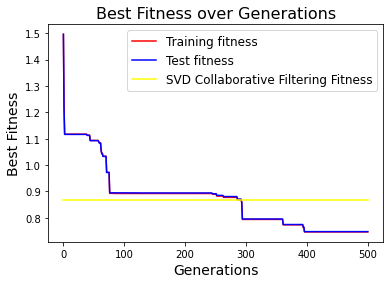

In [94]:
# Extract statistics to plot graphs:

collaborative_filtering = [] 
for i in range(len(min_fitness_values)): 
  collaborative_filtering.append(0.866)

plt.plot(gen, min_fitness_values, color='red', label="Training fitness")
plt.plot(gen, fitness_test, color='blue', label="Test fitness")
plt.plot(gen, collaborative_filtering , color='yellow', label="SVD Collaborative Filtering Fitness")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness over Generations', fontsize=16)
plt.show()

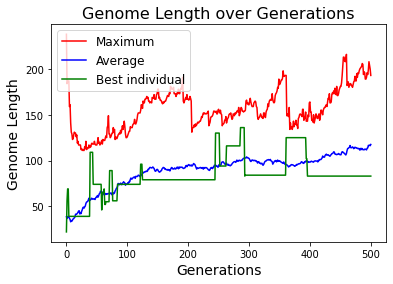

In [95]:
plt.plot(gen, max_length, color='red', label="Maximum")
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()

# Sample Prediction

In [26]:
data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,y
0,0.000000,0.750000,1.000000,0.750000,0.503064,0.000000,0.402985,0.000000,1.000000,0.857143,0.381855,0.500000,0.440678,1.000000,0.015000,0.101124,0.800000,0.356163,0.049821,5
1,0.000000,0.500000,1.000000,0.500000,0.152903,0.000000,0.559701,0.000000,1.000000,0.571429,0.025563,0.500000,0.257627,1.000000,0.190000,0.082397,0.600000,0.043702,0.013233,3
2,0.000000,0.750000,0.000000,0.750000,0.185293,0.000000,0.320896,0.000000,1.000000,0.714286,0.036599,0.500000,0.566102,1.000000,0.085000,0.071161,0.700000,0.041718,0.033217,3
3,0.000000,0.750000,1.000000,0.500000,0.383426,0.000000,0.589552,1.000000,1.000000,0.714286,0.075054,0.500000,0.433898,1.000000,0.260000,0.063670,0.700000,0.103492,0.117155,4
4,0.000000,0.750000,1.000000,0.500000,0.496644,0.000000,0.574627,0.000000,1.000000,0.714286,0.111175,0.500000,0.311864,1.000000,0.600000,0.303371,0.700000,0.318879,0.166064,5


insert back the user_id and movie_id as I removed it previously for GE

In [20]:
ratings_full = pd.read_csv("https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/submission/preprocessed_movielens_1m/ratings.csv")
ratings_full.head()

,Unnamed: 0,user_id,movie_id,rating
0,0,1,1193,5
1,1,1,661,3
2,2,1,914,3
3,3,1,3408,4
4,4,1,2355,5


In [56]:
ratings_new = data.copy(deep=True)
ratings_new['user_id'] = ratings_full['user_id']
ratings_new['movie_id'] = ratings_full['movie_id']
ratings_new.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x12,x13,x14,x15,x16,x17,x18,y,user_id,movie_id
0,0.000000,0.750000,1.000000,0.750000,0.503064,0.000000,0.402985,0.000000,1.000000,0.857143,...,0.440678,1.000000,0.015000,0.101124,0.800000,0.356163,0.049821,5,1,1193
1,0.000000,0.500000,1.000000,0.500000,0.152903,0.000000,0.559701,0.000000,1.000000,0.571429,...,0.257627,1.000000,0.190000,0.082397,0.600000,0.043702,0.013233,3,1,661
2,0.000000,0.750000,0.000000,0.750000,0.185293,0.000000,0.320896,0.000000,1.000000,0.714286,...,0.566102,1.000000,0.085000,0.071161,0.700000,0.041718,0.033217,3,1,914
3,0.000000,0.750000,1.000000,0.500000,0.383426,0.000000,0.589552,1.000000,1.000000,0.714286,...,0.433898,1.000000,0.260000,0.063670,0.700000,0.103492,0.117155,4,1,3408
4,0.000000,0.750000,1.000000,0.500000,0.496644,0.000000,0.574627,0.000000,1.000000,0.714286,...,0.311864,1.000000,0.600000,0.303371,0.700000,0.318879,0.166064,5,1,2355


## Add the new rating score improved by GE

In [57]:
# individual with polish notation: add(x[11],add(mul(x[1],04.57),x[6])) 
# individual with infix notation: x11 + (x1 * 4.57) + x6

ratings_new['GE_rating'] = 0
ratings_new['GE_rating'] = ratings_new['x11'] + (ratings_new['x1'] * 4.57) + ratings_new['x6']
ratings_new.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x13,x14,x15,x16,x17,x18,y,user_id,movie_id,GE_rating
0,0.000000,0.750000,1.000000,0.750000,0.503064,0.000000,0.402985,0.000000,1.000000,0.857143,...,1.000000,0.015000,0.101124,0.800000,0.356163,0.049821,5,1,1193,4.330485
1,0.000000,0.500000,1.000000,0.500000,0.152903,0.000000,0.559701,0.000000,1.000000,0.571429,...,1.000000,0.190000,0.082397,0.600000,0.043702,0.013233,3,1,661,3.344701
2,0.000000,0.750000,0.000000,0.750000,0.185293,0.000000,0.320896,0.000000,1.000000,0.714286,...,1.000000,0.085000,0.071161,0.700000,0.041718,0.033217,3,1,914,4.248396
3,0.000000,0.750000,1.000000,0.500000,0.383426,0.000000,0.589552,1.000000,1.000000,0.714286,...,1.000000,0.260000,0.063670,0.700000,0.103492,0.117155,4,1,3408,4.517052
4,0.000000,0.750000,1.000000,0.500000,0.496644,0.000000,0.574627,0.000000,1.000000,0.714286,...,1.000000,0.600000,0.303371,0.700000,0.318879,0.166064,5,1,2355,4.502127


## Pick a random user to generate predictions for

In [58]:
users_data = pd.read_csv("https://raw.githubusercontent.com/nchichilidze/RS-with-GE/main/data/preprocessed_movielens_1m/users.csv")
user_ids = users_data['user_id']

In [59]:
from random import randrange

random_index = randrange(0, len(user_ids))
random_user = users_data['user_id'][random_index]
random_user

2068

In [60]:
user_rows = ratings_new[ratings_new['user_id'] == random_user]
user_rows.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x13,x14,x15,x16,x17,x18,y,user_id,movie_id,GE_rating
353056,0.000000,0.750000,1.000000,0.500000,0.524657,0.618182,0.753731,1.000000,1.000000,0.714286,...,1.000000,0.350000,0.104869,0.700000,0.193219,0.150770,5,2068,2987,4.681231
353057,0.000000,0.750000,1.000000,0.500000,0.232857,0.618182,0.828358,1.000000,1.000000,0.714286,...,1.000000,0.250000,0.074906,0.700000,0.066503,0.020365,4,2068,2058,4.755858
353058,0.000000,0.750000,1.000000,0.750000,0.520572,0.618182,0.738806,1.000000,1.000000,0.857143,...,1.000000,0.040000,0.074906,0.700000,0.189419,0.023903,4,2068,1259,4.666306
353059,0.000000,0.750000,1.000000,0.500000,0.393931,0.618182,0.783582,1.000000,1.000000,0.857143,...,1.000000,0.140000,0.284644,0.700000,0.402272,0.230427,5,2068,588,4.711082
353060,1.000000,0.750000,1.000000,0.750000,0.772687,0.618182,0.776119,1.000000,1.000000,0.857143,...,1.000000,0.510000,0.288390,0.800000,0.429844,0.237718,4,2068,589,4.703619


In [65]:
# y is the actual rating of the movie VS the GE rating 
user_rows[['y', 'movie_id','GE_rating']]

,y,movie_id,GE_rating
353056,5,2987,4.681231
353057,4,2058,4.755858
353058,4,1259,4.666306
353059,5,588,4.711082
353060,4,589,4.703619
...,...,...,...
353176,3,1223,3.068582
353177,3,1080,2.971567
353178,4,552,3.576045
353179,5,1242,4.688694


In [68]:
# find top 10 movies for the user
user_rows.sort_values(by=['GE_rating'])
user_rows[['y', 'movie_id','GE_rating']].head(10)

,y,movie_id,GE_rating
353056,5,2987,4.681231
353057,4,2058,4.755858
353058,4,1259,4.666306
353059,5,588,4.711082
353060,4,589,4.703619
353061,5,1,4.733470
353062,4,1408,4.711082
353063,5,1265,4.718545
353064,4,733,4.740933
353065,4,590,4.696157
